# Librerias

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error

plt.style.use('fivethirtyeight')

# Data
Demanda energia en australia, varibles xogenas como la temp y si fue feriado

In [2]:
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/vic_elec.csv'
data=pd.read_csv(url)
data.head()


,Time,Demand,Temperature,Date,Holiday
0,2011-12-31T13:00:00Z,4382.825174,21.40,2012-01-01,True
1,2011-12-31T13:30:00Z,4263.365526,21.05,2012-01-01,True
2,2011-12-31T14:00:00Z,4048.966046,20.70,2012-01-01,True
3,2011-12-31T14:30:00Z,3877.563330,20.55,2012-01-01,True
4,2011-12-31T15:00:00Z,4036.229746,20.40,2012-01-01,True


# Exploracion del conjutno de datos

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


In [4]:
data['Time'] = pd.to_datetime(data['Time'],format='%Y-%m-%dT%H:%M:%SZ')
data=data.set_index('Time')
data = data.asfreq('30min')
data=data.sort_index()
data.head()


,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True
2011-12-31 14:00:00,4048.966046,20.70,2012-01-01,True
2011-12-31 14:30:00,3877.563330,20.55,2012-01-01,True
2011-12-31 15:00:00,4036.229746,20.40,2012-01-01,True


In [6]:
(data.index==pd.date_range(start=data.index[0],end=data.index.max(),freq=data.index.freq)).all()

True

In [7]:
data = data.drop('Date', axis=1)
data= data.resample(rule='H',closed='left',label='right').mean()
data

,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0
2011-12-31 15:00:00,3963.264688,20.625,1.0
2011-12-31 16:00:00,3950.913495,20.325,1.0
2011-12-31 17:00:00,3627.860675,19.850,1.0
2011-12-31 18:00:00,3396.251676,19.025,1.0
...,...,...,...
2014-12-31 09:00:00,4069.625550,21.600,0.0
2014-12-31 10:00:00,3909.230704,20.300,0.0
2014-12-31 11:00:00,3900.600901,19.650,0.0


In [10]:
# Splitting data
data=data.loc['2012-01-01 00:00:00':'2014-12-30 00:00:00']
train_end = '2013-12-31 23:59:00'
test_end = '2014-11-30 23:59:00'
data_train = data.loc[: train_end,:]
data_test = data.loc[train_end:test_end,:]
data_val = data.loc[test_end:,:]
print(data_train.index.min(), data_train.index.max())
print(data_test.index.min(), data_test.index.max())
print(data_val.index.min(), data_val.index.max())


2012-01-01 00:00:00 2013-12-31 23:00:00
2014-01-01 00:00:00 2014-11-30 23:00:00
2014-12-01 00:00:00 2014-12-30 00:00:00


<Axes: xlabel='Time'>

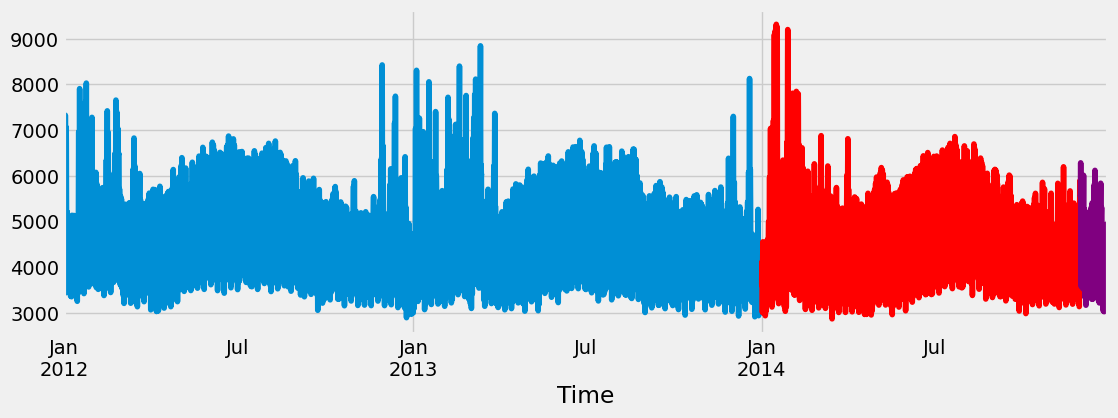

In [16]:
# Plot
fig, ax = plt.subplots(figsize=(12,4))
data_train.Demand.plot(ax=ax, label='Train')
data_test.Demand.plot(ax=ax, label='Test', color='red')
data_val.Demand.plot(ax=ax, label='Val', color='purple')



<Axes: title={'center': 'Demand'}, xlabel='month'>

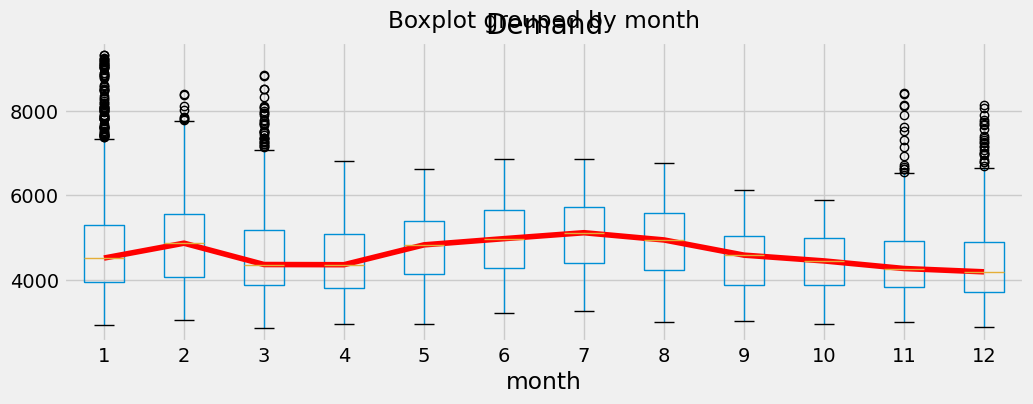

In [17]:
#Identity estacionalidad
fig, ax=plt.subplots(figsize=(12,4))
data['month'] =data.index.month
data.boxplot(column='Demand',by='month',ax=ax)
data.groupby('month')['Demand'].median().plot(ax=ax, color='red')

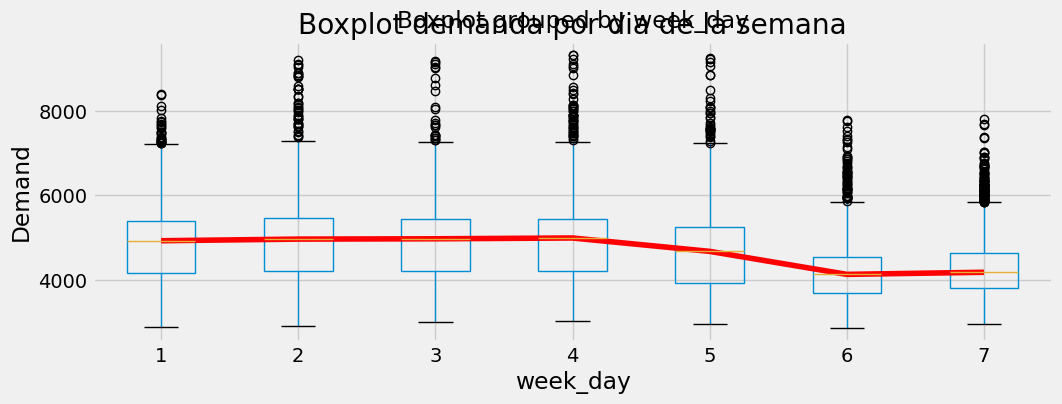

In [21]:
#Identificar estacionalidad semanal
fig,ax=plt.subplots(figsize=(12,4))
data['week_day']=data.index.day_of_week+1
data.boxplot(column='Demand',by='week_day',ax=ax)
data.groupby('week_day')['Demand'].median().plot(ax=ax,color='red')
ax.set_ylabel('Demand')
ax.set_title('Boxplot demanda por dia de la semana')
plt.show()